In [1]:
!pip install tensorflow==2.14.1 opencv-python matplotlib

^C


In [1]:
#Siamese Neural Network

In [2]:
#Standard Library
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#tensorflow dependency - Functional API
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#GPU Setup - Consumption

# # # gpus=tf.config.experimental.list_physical_devices('GPU')
# # for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
#Setting Paths

POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [6]:
# #Make Directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [ ]:
# https://vis-www.cs.umass.edu/lfw/

#Uncompressing File
!tar -xf lfw.tgz

In [ ]:
#Moving Images to data/negative directory

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH,NEW_PATH)

In [168]:
#uuid library to generate unique image names
import uuid

In [169]:
uuid.uuid1()

UUID('68fd1c52-d5ff-11ee-b288-f4ee089effb9')

In [172]:
#Establishing Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #Cut down frame to 250x250
    frame = frame[150:150+250,230:230+250,:]
    
    #Collecting Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #Unique File Path and naming frame
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #Collecting Anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Unique File Path and naming frame
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #show image back to screen
    cv2.imshow('Smile', frame)
    
    #Break the loop with 'q' button press
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

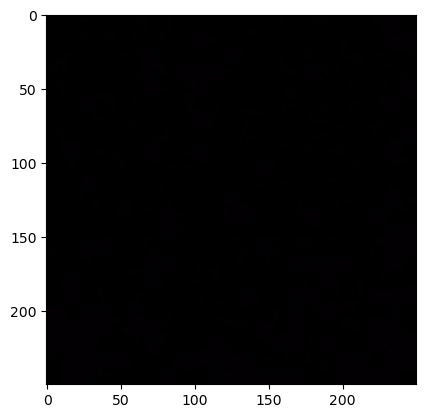

In [173]:
plt.imshow(frame)

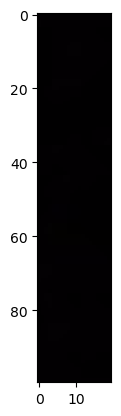

In [174]:
plt.imshow(frame[150:150+250,230:230+250,:])

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(400)

In [8]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\f27accbd-c0c0-11ee-88f6-f4ee089effb9.jpg'

In [9]:
POS_PATH+'\*.jpg'

'data\\positive\\*.jpg'

In [10]:
#Preprocessing and scaling data

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) #Reading Image
    img = tf.io.decode_jpeg(byte_img) #Load Image
    
    #resizing to 100x100 according to paper
    img = tf.image.resize(img, (100,100))
    img = img/255.0 #Scaling image between 0 & 1
    return img

In [11]:
img = preprocess('data\\anchor\\f5728e8f-c0c0-11ee-bca5-f4ee089effb9.jpg')
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.8784314 , 0.84705883, 0.8039216 ],
        [0.8784314 , 0.84705883, 0.8039216 ],
        [0.8754902 , 0.85      , 0.8039216 ],
        ...,
        [0.8303922 , 0.79509807, 0.7362745 ],
        [0.8333333 , 0.7980392 , 0.7392157 ],
        [0.82254905, 0.7872549 , 0.72843134]],

       [[0.87941176, 0.84607846, 0.8039216 ],
        [0.87916666, 0.84632355, 0.8039216 ],
        [0.8784314 , 0.84705883, 0.8039216 ],
        ...,
        [0.83137256, 0.79607844, 0.7372549 ],
        [0.8252451 , 0.78995097, 0.73112744],
        [0.827451  , 0.7921569 , 0.73333335]],

       [[0.88235295, 0.84313726, 0.8039216 ],
        [0.88210785, 0.84338236, 0.8039216 ],
        [0.87916666, 0.84632355, 0.8039216 ],
        ...,
        [0.8306373 , 0.79534316, 0.73651963],
        [0.827451  , 0.7921569 , 0.73333335],
        [0.8303922 , 0.79509807, 0.73039216]],

       ...,

       [[0.84289217, 0.7919118 , 0.75759804],
        [0.84

In [12]:
img.numpy().min()
# img.numpy().max()

0.075

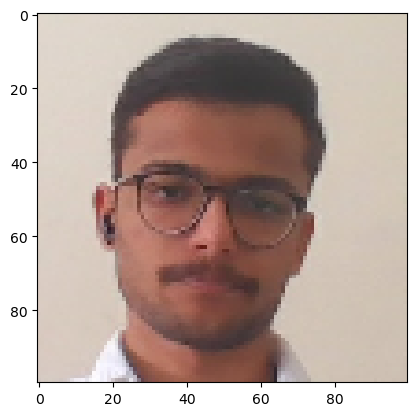

In [13]:
plt.imshow(img)

In [14]:
#Creating labelled dataset

positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [16]:
samples = data.as_numpy_iterator()

In [17]:
example = samples.next()

In [18]:
example

(b'data\\anchor\\ff541611-c0c0-11ee-8606-f4ee089effb9.jpg',
 b'data\\positive\\0d119be5-c0c1-11ee-b76c-f4ee089effb9.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*example)

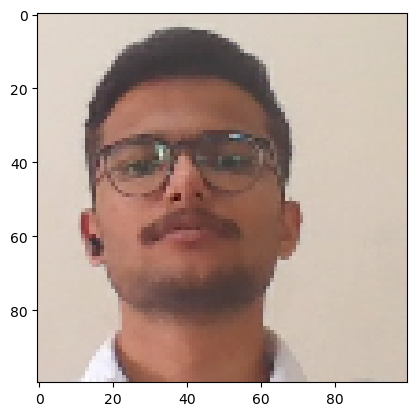

In [21]:
plt.imshow(res[1])

In [22]:
res[2]

1.0

In [23]:
#Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [24]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [25]:
samples = data.as_numpy_iterator()

In [26]:
samp = samples.next()

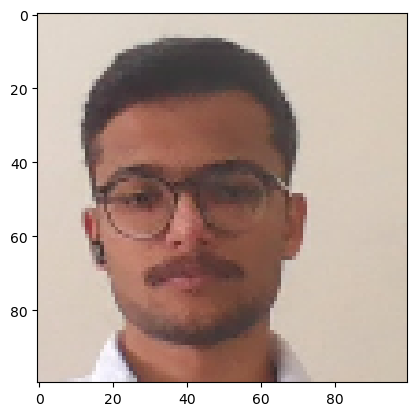

In [27]:
plt.imshow(samp[1])

In [28]:
samp[2]

1.0

In [29]:
#training partition

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [31]:
train_samples = train_data.as_numpy_iterator()

In [32]:
train_sample = train_samples.next()

In [33]:
train_sample

(array([[[[0.87058824, 0.8352941 , 0.8       ],
          [0.87941176, 0.8401961 , 0.80490196],
          [0.88161767, 0.842402  , 0.80710787],
          ...,
          [0.8264706 , 0.7911765 , 0.7323529 ],
          [0.8252451 , 0.78995097, 0.73112744],
          [0.82254905, 0.78333336, 0.7362745 ]],
 
         [[0.872549  , 0.8362745 , 0.8009804 ],
          [0.8752451 , 0.8360294 , 0.8007353 ],
          [0.8813726 , 0.8421569 , 0.8068628 ],
          ...,
          [0.827451  , 0.7921569 , 0.73333335],
          [0.827451  , 0.7921569 , 0.73333335],
          [0.8235294 , 0.7852941 , 0.7352941 ]],
 
         [[0.8754902 , 0.8362745 , 0.8009804 ],
          [0.8747549 , 0.8362745 , 0.8009804 ],
          [0.8754902 , 0.8392157 , 0.8039216 ],
          ...,
          [0.8242647 , 0.7948529 , 0.7286765 ],
          [0.82058823, 0.7911765 , 0.7294118 ],
          [0.8235294 , 0.7941176 , 0.7323529 ]],
 
         ...,
 
         [[0.8262255 , 0.7879902 , 0.7884804 ],
          [0.82745

In [34]:
#Testing Partition

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [35]:
def make_embedding():
    inp = Input(shape=(100,100,3),name = 'input_name')
    #First block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    #Second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
    #Third block
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    #Fourth block
    c4 = Conv2D(256,(4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=d1,name='embedding')

In [36]:
# inp = Input(shape=(100,100,3),name = 'input_name')
# c1 = Conv2D(64,(10,10), activation='relu')(inp)
# m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

# inp = Input(shape=(100,100,3),name = 'input_name')
# #First block
# c1 = Conv2D(64,(10,10), activation='relu')(inp)
# m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
# #Second block
# c2 = Conv2D(128,(7,7), activation='relu')(m1)
# m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
# #Third block
# c3 = Conv2D(128,(4,4), activation='relu')(m2)
# m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
# #Fourth block
# c4 = Conv2D(256,(4,4), activation='relu')(m3)
# f1 = Flatten()(c4)
# d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
# c4

In [38]:
# 6*6*256

In [39]:
# f1

In [40]:
# d1

In [41]:
#Our model
embedding = make_embedding()

In [42]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_name (InputLayer)     [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [43]:
#Siamese Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [44]:
l1 = L1Dist()
l1

In [45]:
def make_siamese_model():
    
    #anchor image input
    input_image = Input(name='input_img', shape=(100,100,3))
    #validation image input
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #combining siamese components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [46]:
siamese_model = make_siamese_model()

In [47]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [48]:
#Settingup loss function

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [49]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [50]:
# siamese_model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [52]:
# model = tf.keras.models.load_model('siamesemodel.h5', 
#                                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [53]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
#Training Step Function

In [55]:
@tf.function

def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        #Forward Pass
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
        
    #calculating gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    #Calculate updated weights and apply to model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [56]:
#Training Loop

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        #Save epoch every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [216]:
#Training the model

EPOCHS = 1

In [160]:
train(train_data, EPOCHS)


 Epoch 1/1
 9/35 [======>.......................] - ETA: 9:11

KeyboardInterrupt: 

In [57]:
from tensorflow.keras.metrics import Precision, Recall

In [58]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [59]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[0.49974135],
       [0.49968976],
       [0.49990207],
       [0.49959332],
       [0.50050306],
       [0.49833208],
       [0.49974877],
       [0.49836457],
       [0.49988526],
       [0.49934512],
       [0.5013896 ],
       [0.5002281 ],
       [0.49978364],
       [0.50002134],
       [0.49977115],
       [0.49972582]], dtype=float32)

In [60]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]

In [61]:
y_true

array([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [62]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.14285715

In [63]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.25

In [64]:
# # Set plot size 
# plt.figure(figsize=(10,8))

# # Set first subplot
# plt.subplot(1,2,1)
# plt.imshow(test_input[0])

# # Set second subplot
# plt.subplot(1,2,2)
# plt.imshow(test_val[0])

# # Renders cleanly
# plt.show()

In [65]:
# Save weights

# Commented for safety
# siamese_model.save('siamesemodel.h5')

In [66]:
L1Dist

__main__.L1Dist

In [81]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [82]:
# model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [83]:
model.input_shape

[(None, 100, 100, 3), (None, 100, 100, 3)]

In [84]:
# model.load_weights(checkpoint_path)

In [85]:
# for layer in model.layers:
#     print(f"Layer: {layer.name}")
#     weights = layer.get_weights()  # Get the weights of the layer
#     if weights:
#         for i, w in enumerate(weights):
#             print(f"  Weight {i + 1}: {w.shape}")
#     else:
#         print("  No weights")
#     print()

In [86]:
# model = tf.keras.models.load_model('siamesemodel.h5', 
#                                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# # Now you can manually compile the model later if needed
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
# Make predictions with reloaded model
pr = model.predict([test_input, test_val])
pr

1/1 [==============================] - 2s 2s/step


array([[9.9999982e-01],
       [9.9999940e-01],
       [1.0284330e-11],
       [1.0000000e+00],
       [4.8974239e-14],
       [7.4158554e-11],
       [1.0000000e+00],
       [2.3973856e-10],
       [7.6609042e-13],
       [1.0730891e-11],
       [4.1961882e-13],
       [3.4331937e-13],
       [9.9999958e-01],
       [9.9999994e-01],
       [1.4109864e-07],
       [9.9999988e-01]], dtype=float32)

In [93]:
[1 if prediction > 0.5 else 0 for prediction in pr ]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]

In [117]:
# model.load_weights(checkpoint_dir)
# os.listdir(checkpoint_dir)

In [88]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

In [89]:
# model.load_weights(latest)

In [119]:
# model.load_weights(latest)

In [97]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [71]:
# os.listdir(os.path.join('app_data','verification_images'))

In [98]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('app_data','verification_images')):
        input_img = preprocess(os.path.join('app_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('app_data','verification_images',image))
        
        #Predicting
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    #detection threshold calculation
    detection = np.sum(np.array(results) > detection_threshold)
    #verification threshold calculation
    verification = detection / len(os.listdir(os.path.join('app_data','verification_images')))
    verified = verification >= verification_threshold
    
    return results, verified

In [108]:
#OpenCV Real Time Detection

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[150:150+250,230:230+250,:]
    
    # Fliping the image
    flip = cv2.flip(frame,1)
 
    cv2.imshow('Verification', flip)
#     cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('app_data','input_image','input_image.jpg'), frame)
        #Verifiying
        results, verified = verify(model, 0.9, 0.9)
        print(verified)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 240ms/step
True


In [109]:
np.sum(np.squeeze(results) > 0.9)

50

In [110]:
results

[array([[0.9999432]], dtype=float32),
 array([[0.99993914]], dtype=float32),
 array([[0.9997232]], dtype=float32),
 array([[0.9997829]], dtype=float32),
 array([[0.9999432]], dtype=float32),
 array([[0.9999748]], dtype=float32),
 array([[0.9999718]], dtype=float32),
 array([[0.99999475]], dtype=float32),
 array([[0.99998236]], dtype=float32),
 array([[0.99999267]], dtype=float32),
 array([[0.9999991]], dtype=float32),
 array([[0.9999994]], dtype=float32),
 array([[0.9999991]], dtype=float32),
 array([[0.99991393]], dtype=float32),
 array([[0.99999714]], dtype=float32),
 array([[0.99999535]], dtype=float32),
 array([[0.99999946]], dtype=float32),
 array([[0.9999994]], dtype=float32),
 array([[0.99999136]], dtype=float32),
 array([[0.99998933]], dtype=float32),
 array([[0.99987674]], dtype=float32),
 array([[0.99999535]], dtype=float32),
 array([[0.99999946]], dtype=float32),
 array([[0.9999871]], dtype=float32),
 array([[0.9999884]], dtype=float32),
 array([[0.9999616]], dtype=float32),

In [107]:
26/50

0.52

In [86]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("Available GPU devices:")
    for device in physical_devices:
        print(device)
else:
    print("No GPU devices available.")

No GPU devices available.
